# Analýza zlúčiteľnosti datasetov Text2Bank a Banking77

v tejto analýze sa venujeme
- podobnosťami názvov tried v oboch datasetoch
- možnosti zlúčenia niektorých tried z oboch datasetov
- klasifikáciou spojených datasetov pomocou transfer learningu FERNET neurónovej siete 

In [5]:
from laserembeddings import Laser
import pandas as pd
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, top_k_accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize


import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use("seaborn")

import umap

from sklearn.cluster import KMeans

In [2]:
laser = Laser()

In [3]:
from sentence_transformers import SentenceTransformer

fernet = SentenceTransformer("fav-kky/FERNET-C5")

2022-03-08 12:49:47.673040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 12:49:47.673090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at /home/sfabo/.cache/torch/sentence_transformers/fav-kky_FERNET-C5 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g

In [4]:
import fasttext
ft = fasttext.load_model('cc.cs.300.bin')

## Podobnosť názvov tried datasetov Banking77 a text2bank

### Čo chceme ukázať?

- najpodobnejšie názvy tried (pomocou LASER embeddingov a kosínovej podobnosti)
- maticu podobností spočítanú pomocou $K(b_i, t_j)$, kde $b_i$ sú názvy tried B77 datasetu a $t_j$ sú názvy tried t2b datasetu.

### Hypotéza

- Sú nejaké triedy z oboch datasetov zlúčiteľné dohromady?

In [3]:
import pandas as pd
b77 = pd.read_csv('data_text2bank/cs_banking77/banking-train-translated.csv')
t2b = pd.read_csv('data_text2bank/clean-pairs-enhanced-sort.csv').dropna()
b77_cls = np.sort(b77['category'].str.replace('_', ' ').unique())
b77_cls_idxs = np.argsort(b77['category'].str.replace('_', ' ').unique())
b77_cls_cz = np.array(b77['kategorie'].unique())[b77_cls_idxs]

t2b_cls = sorted(t2b['kategorie'].str.replace('_', ' ').unique())
t2b_cls_emb = laser.embed_sentences(t2b_cls, lang='cs')
b77_cls_emb = laser.embed_sentences(b77_cls, lang='en')
cos_simil = cosine_similarity(t2b_cls_emb, b77_cls_emb)
res = {t: [] for t in t2b_cls}
for i in range(3):
    top1 = cos_simil.argmax(axis=1)
    top1_vals = cos_simil.max(axis=1)

    b77_cls = np.array(b77_cls)
    # {t: (n, b) for t, b, n in zip(t2b_cls, b77_cls[top1], np.round(top1_vals, 3))}
    [res[t].append((n, b)) for t, b, n in zip(t2b_cls, b77_cls[top1], np.round(top1_vals, 3))]

    cos_simil[np.arange(13), top1] = 0
cos_simil = cosine_similarity(t2b_cls_emb, b77_cls_emb)

In [97]:
cs = cos_simil.copy()
t0 = np.argmax(cs, axis=1)
cs[np.array(range(13)), t0] = 0

t1 = np.argmax(cs, axis=1)
cs[np.array(range(13)), t1] = 0

t2 = np.argmax(cs, axis=1)
cs[np.array(range(13)), t2] = 0

best_idxs = np.unique(np.concatenate([t0, t1, t2]))
css = np.full(cos_simil.shape, 0.).T
print(css.shape)
css[t0, range(13)] = cos_simil.T[t0, range(13)]
css[t1, range(13)] = cos_simil.T[t1, range(13)]
css[t2, range(13)] = cos_simil.T[t2, range(13)]

(77, 13)


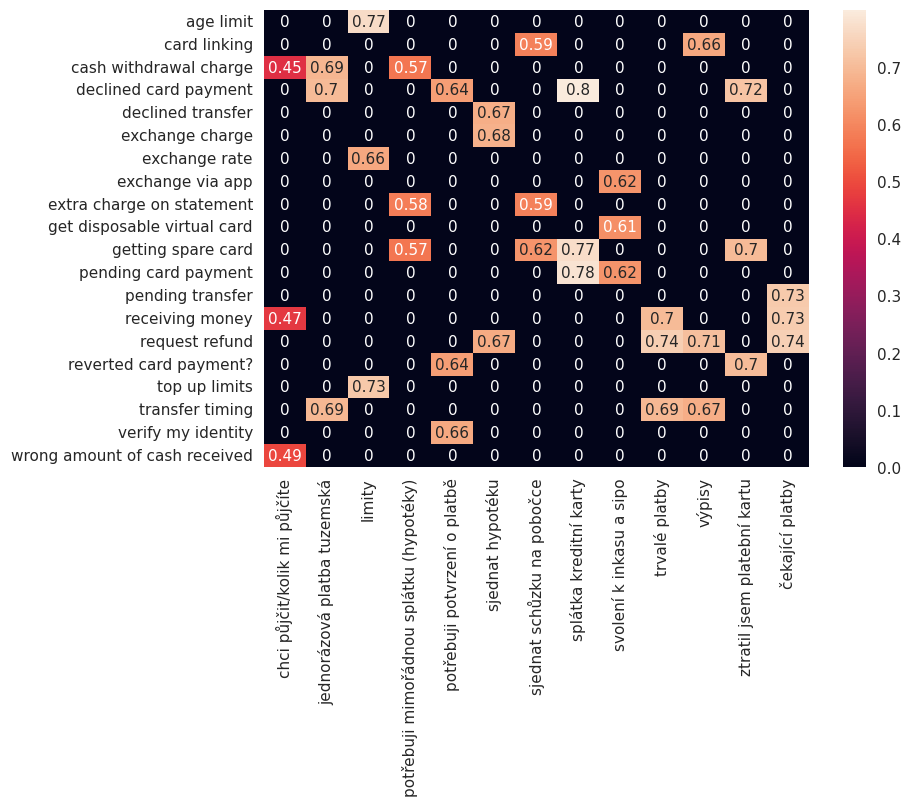

In [98]:

plt.figure(dpi=110)
# sns.heatmap(cs.T, annot=True, xticklabels=t2b_cls, yticklabels=b77_cls)
sns.heatmap(css[best_idxs], annot=True, xticklabels=t2b_cls, yticklabels=b77_cls[best_idxs])
# sns.heatmap(cos_simil.T[best_idxs], annot=True, xticklabels=t2b_cls, yticklabels=b77_cls[best_idxs])
plt.show()

### Pozorovanie

- pozeráme sa na najpodobnejšie názvy tried z datasetu banking77 ku názvom tried z datasetu text2bank (pomocou kosínovej podobnosti LASER embeddingov).
- top3 najpodobnejšie sú vyznačené, ostatné sú pre prehľadnosť nahradené 0.
- prejdime niektoré zaujímavé triedy zvlášť:
  - napr. "chci půjčit..." nie je podobná skoro s ničím. Môže to byť spôsobené lomítkom v názve.
  - "limity" sú podobné s "age limit" a "top up limits", kde sa obsahovo najpodobnejšia zdá práve trieda top up limits
  - "trvalé platby" by mohli byť podobné s "transfer timing", avšak toto je nutné overiť.
  - "čekající platby" by mohli byť podobné s "pending transfer".

### Záver

- asi iba 3 páry z top3 výsledkov vyššie sa javia ako dostatočne sémanticky podobné:
  - "top up limit" ku "limity" 
  - "pending transfer" ku "čekající platby"
  - "transfer timing" ku "trvalé platby"
- bolo prevedené manuálne (pozrem a vidím) párovanie EN ku CZ triedam a bol objavený ďalší možný 1 pár:
  - "Lost or stolen card" ku "ztratil jsem platební kartu"

Na tieto 4 páry si posvietime nižšie.

## Intenty z triedy "Lost or stolen card" (B77) podobné s intentami "ztratil jsem platební kartu" (t2b)

- pre presnosť použime originálne znenia intentov z B77 datasetu a použime LASER s anglickým jazykom, intenty z t2b embedujme v českom jazyku

### Čo chceme ukázať?

- zoberme top 10 najpodobnejších intentov a 10 najmenej podobných z oboch tried rozličných datasetov a porovnajme ich podobnosti pomocou LASERu.

### Hypotéza

- sú tieto dve triedy zlúčiteľné dohromady?

In [105]:
b77_lost = np.array(b77[b77['category'] == 'lost_or_stolen_card']['text'])
t2b_lost = np.array(t2b[t2b['kategorie'] == 'ztratil jsem platební kartu']['text_cz'])

print(f'ztratil jsem platební kartu: #t2b intentov: {len(t2b_lost)}, \n lost_or_stolen_card: #b77 intentov: {len(b77_lost)}\n')

b77_lost_emb = laser.embed_sentences(b77_lost, lang='en')
t2b_lost_emb = laser.embed_sentences(t2b_lost, lang='cz')


cos_simil = cosine_similarity(t2b_lost_emb, b77_lost_emb)

top1 = np.argmax(cos_simil, axis=1)
top1_vals = np.max(cos_simil, axis=1)

b77_lost[top1]

res = sorted([(n, t, b) for t, b, n in zip(t2b_lost, b77_lost[top1], np.round(top1_vals, 3))], key=lambda x: x[0], reverse=True)

print('TOP10: \n', res[1:11])
print('LOW10: \n', res[23:])

ztratil jsem platební kartu: #t2b intentov: 33, 
 lost_or_stolen_card: #b77 intentov: 66

TOP10: 
 [(0.836, 'Ukradli mi kartu!', 'Someone stole my card!'), (0.824, 'ukradli mi kreditku', 'My card was stolen'), (0.815, 'Přišel jsem o kreditku, co mam dělat?', 'I lost my card, what do I do now?'), (0.796, 'ukradli mi platební kartu', 'My card was stolen'), (0.783, 'odcizili mi kartu', 'My card was stolen'), (0.782, 'ztratil jsem kartu', 'My card is missing.'), (0.782, 'ztratil jsem kartu', 'My card is missing.'), (0.758, 'Asi mi byla odcizena karta', 'My card was stolen'), (0.753, 'někdo mi ukradl kartu!!!!!', 'Someone stole my card!'), (0.744, 'Ztratil jsem platební kartu', 'I lost track of my card')]
LOW10: 
 [(0.654, 'Nechal jsem peněženku ve vlaku.', 'I lost my wallet and all my cards were in it.'), (0.652, 'nechal jsem kreditku v obchodě', 'I left my card at a restaurant and now its missing.'), (0.647, 'Kde mám kartu?', 'My card is missing.'), (0.642, 'zablokovat kartu', 'Report sto

### Pozorovanie

- hore vidíme zoznam top/low 10 najpodobnejších českých a anglických intentov
- čísla kos. podobnosti je v prvej desiatke sú pomerne vysoké: 0,84 až 0,74
  - kazdý záznam je tvorený trojicou: cos simil, cz intent z t2b, en intent z b77.
- napr. "ztratil jsem kartu" je najpodobnejšie ku "lost my card" (čo vskutku sedí).
- naopak, "Ztratil jsem telefon s Google Pay" by bolo lepšie klasifikovať do anglickej B77 triedy "lost or stolen phone" (áno, aj takáto trieda sa v B77 nachádza)

### Záver

- javí sa, že intenty týchto dvoch tried sú si ozaj podobné, až na pár výnimiek.
- je tu teda možnosť ich potenciálneho zlúčenia po čistení, viď. "Ztratil jsem telefon s Google Pay".

## Klastering intentov z tried "Lost or stolen card" (B77) a "ztratil jsem platební kartu" (t2b)

### Čo chceme ukázať?

- vizualizáciu embeddingov intentov z oboch tried v 2 dimenziách (pomocou UMAPu)
- KMeans klastrovanie LASER embeddingov ale v 2D zobrazení UMAP embeddingov

### Hypotéza

- sú tieto dve triedy zlúčiteľné?

poznámka: UMAP parametre v poradí: `n_neighbors, min_dist, metric`

UMAP params: (10, 0.9, 'cosine')


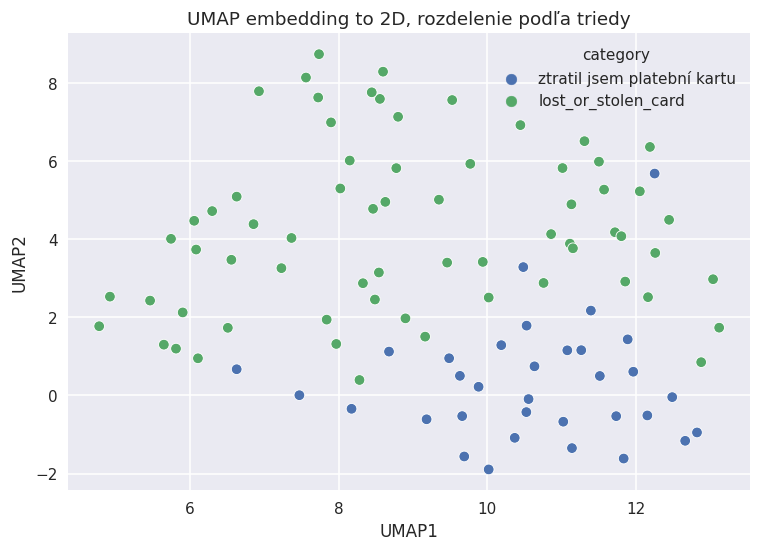

In [ ]:
# b77 = pd.read_csv('data_text2bank/cs_banking77/banking-test-translated.csv')
# t2b = pd.read_csv('data_text2bank/clean-pairs-enhanced-sort.csv').dropna()

import itertools

for nei, md, metr in itertools.product([10], [.9], ['cosine']):
    # u = umap.UMAP(metric='cosine', random_state=999, n_neighbors=15, min_dist=.1)
    print('UMAP params:', (nei, md, metr))
    u = umap.UMAP(metric=metr, random_state=999, n_neighbors=nei, min_dist=md)
    b77_samp = b77[b77['category'] == 'lost_or_stolen_card'][['text', 'category']]
    t2b_samp = t2b[t2b['kategorie'] == 'ztratil jsem platební kartu'][['text_cz', 'kategorie']]

    b77_embds_laser = laser.embed_sentences(b77_samp['text'], lang='en')
    t2b_embds_laser = laser.embed_sentences(t2b_samp['text_cz'], lang='cs')

    laser_both = np.concatenate([b77_embds_laser, t2b_embds_laser])

    ebds = u.fit_transform(laser_both)

    b77_samp['laser'] = b77_embds_laser.tolist()
    t2b_samp['laser'] = t2b_embds_laser.tolist()

    t2b_samp.columns = ['text', 'category', 'laser']

    data = pd.concat([b77_samp, t2b_samp]).reset_index()
    ebds = u.fit_transform(data['laser'].tolist())
    embedding = pd.DataFrame(ebds, columns = ['UMAP1','UMAP2'])

    # embedding, data
    embedding = pd.concat([data, embedding], axis='columns').sample(frac=1).reset_index(drop=True)
    kmeans = KMeans(n_clusters=2, random_state=42).fit(laser_both)
    embedding['kmeans'] = kmeans.labels_
    plt.figure(dpi=110)
    sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='category')
    plt.title('UMAP embeddingy do 2D, rozdelenie podľa triedy')
    plt.show()

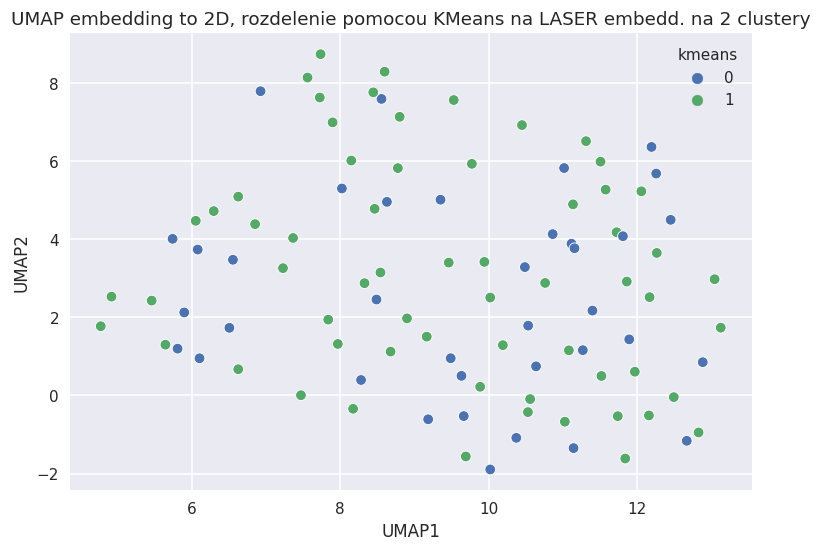

In [ ]:
plt.figure(dpi=110)
sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='kmeans')
plt.title('UMAP embeddingy do 2D, rozdelenie pomocou KMeans na LASER embedd. na 2 klastre')
plt.show()

### Pozorovanie

#### Graf 1

- na grafe 1 je farebné odlíšenie bodov v 2D UMAP priestore podľa príslušiacej triedy 
- vidíme tu, že sa napriek tomu, že body oboch tried sa príliš neprekrývajú - UMAP nebol schopný nájsť rozličnosť v embeddingoch.
  - to, že sú body rovnakej triedy blízko seba a tvoria pomyselný cluster mohlo byť spôsobené práve rozličnými jazykmi

#### Graf 2

- použili sme KMeans algoritmus na nájdenie klastrov (v tomto prípade by sme očakávali práve 2 klastre)
- je viditeľné, že ak **v priestore laser embeddingov** existujú aspoň 2 klastre, sú určite rozličné od originál "klastrovania" podľa triedy
- KMeans klastrovanie je pomerne chaotické

### Záver

- tieto dve triedy, zdá sa, majú spoločný prekryv. Je to viditeľné hlavne na UMAP vizualizácii v grafe 1
  - potvrdzuje to aj vizualizácia KMeans klastrov na UMAPe
- zdá sa, že by tu bolo možné tieto dve triedy zlúčiť

## Intenty z triedy "pending transfer" (B77) podobné s intentami "čekající platby" (t2b)

- pre presnosť použime originálne znenia intentov z B77 datasetu a použime LASER s anglickým jazykom

### Čo chceme ukázať?

- zoberme top/low 10 najpodobnejších intentov z oboch tried rozličných datasetov a porovnajme ich podobnosti pomocou LASERu.

### Hypotéza

- sú tieto dve triedy zlúčiteľné dohromady?

In [103]:
b77_lost = np.array(b77[b77['category'] == 'pending_transfer']['text'])
t2b_lost = np.array(t2b[t2b['kategorie'] == 'čekající platby']['text_cz'])

print(f'čekající platby: #t2b intentov: {len(t2b_lost)}, \npending_transfer: #b77 intentov: {len(b77_lost)}\n')

b77_lost_emb = laser.embed_sentences(b77_lost, lang='en')
t2b_lost_emb = laser.embed_sentences(t2b_lost, lang='cz')


cos_simil = cosine_similarity(t2b_lost_emb, b77_lost_emb)

top1 = np.argmax(cos_simil, axis=1)
top1_vals = np.max(cos_simil, axis=1)

b77_lost[top1]

res = sorted([(n, t, b) for t, b, n in zip(t2b_lost, b77_lost[top1], np.round(top1_vals, 3))], key=lambda x: x[0], reverse=True)

print('TOP12: \n', res[:12])
print('LOW12: \n', res[12:])

čekající platby: #t2b intentov: 24, 
pending_transfer: #b77 intentov: 130

TOP12: 
 [(0.74, 'mám nějaké naplánované platby?', 'Is my transfer pending?'), (0.716, 'jaké mam čekající platby', 'I have a pending transaction'), (0.714, 'jaké platby se ještě neprovedli', 'My money transfer has not yet occurred'), (0.699, 'Všechny platby proběhly?', 'Is my transfer pending?'), (0.699, 'mám nějakou nezrealizovanou platbu?', 'Is my transfer pending?'), (0.695, 'jaké mám čekají platby?', 'Why is my transfer pending?'), (0.693, 'Chci vidět seznam čekajících plateb.', 'I have a transfer waiting.'), (0.693, 'Jaké platby mám zadané k úhradě?', 'Is my transfer pending?'), (0.689, 'kolik mám do konce měsíce naplánovaných výdavků?', 'How long does it take for a transfer to finish pending?'), (0.672, 'kolik plateb ještě zbývá a které jsou na čekačce?', 'How long will my transfer stay pending?'), (0.672, 'rezervované platby', 'I have a pending money transfer'), (0.664, 'nezaúčtované platby', 'I have a pe

### Pozorovanie

- hore vidíme zoznam českých a anglických intentov a ich kosínovej podobnosti. vypísané sú všetky.
  - kazdý záznam je tvorený trojicou: cos simil, cz intent, en intent.
- čísla kos. podobnosti v prvej desiatke sú nižšie ako pri predchádzajúcom porovnaní intentov: 0,74 až 0,66
- napr. kosínovo najpodobnejší pár: "jaké mam čekající platby" ku 'I have a pending transfer' - intenty sa javia byť sémanticky dosť rozdielne
  - V prvom prípade zámer zobrazenia, v druhom len fakt divná veta (áno, máš čakajúcu platbu. Gratulujeme).
- prípadne, pár 'mám nějaké naplánované platby?' a 'Pending transfer?' je ukážkou zlej granularity a nie príliš vysokej dátovej kvality B77 datasetu.

### Záver

- tieto triedy majú obe jednak nízku sémantickú granularitu a jednak sa javia nie príliš podobné
- bolo by vhodné intenty z t2b a B77 pretriediť a zvoliť vyššiu granularitu
- zlúčenie by bolo možné, avšak zdá sa, že je tu nutnosť dáta predtým manuálne (sémanticky) očistiť a rozprestrieť do "podtried".


## Klastrovanie intentov z tried "pending transfer" (B77) a "čekající platby" (t2b)

### Čo chceme ukázať?

- vizualizáciu embeddingov intentov z oboch tried v 2 dimenziách (pomocou UMAPu)
- KMeans klastrovanie LASER embeddingov ale v 2D zobrazení UMAP embeddingov

### Hypotéza

- sú tieto dve triedy zlúčiteľné?

UMAP params: (10, 0.9, 'cosine')


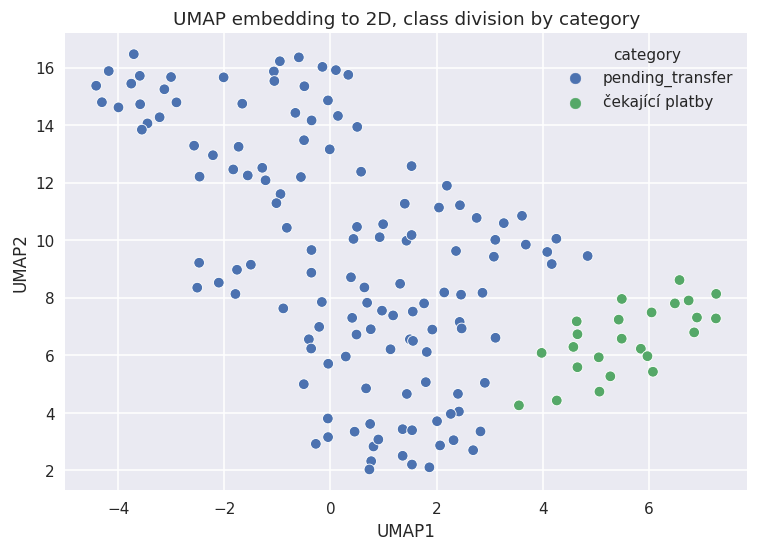

In [6]:
import itertools

for nei, md, metr in itertools.product([10], [.9], ['cosine']):
    # u = umap.UMAP(metric='cosine', random_state=999, n_neighbors=15, min_dist=.1)
    print('UMAP params:', (nei, md, metr))
    u = umap.UMAP(metric=metr, random_state=999, n_neighbors=nei, min_dist=md)
    b77_samp = b77[b77['category'] == 'pending_transfer'][['text', 'category']]
    t2b_samp = t2b[t2b['kategorie'] == 'čekající platby'][['text_cz', 'kategorie']]

    b77_embds_laser = laser.embed_sentences(b77_samp['text'], lang='en')
    t2b_embds_laser = laser.embed_sentences(t2b_samp['text_cz'], lang='cs')

    laser_both = np.concatenate([b77_embds_laser, t2b_embds_laser])

    ebds = u.fit_transform(laser_both)

    b77_samp['laser'] = b77_embds_laser.tolist()
    t2b_samp['laser'] = t2b_embds_laser.tolist()

    t2b_samp.columns = ['text', 'category', 'laser']

    data = pd.concat([b77_samp, t2b_samp]).reset_index()
    ebds = u.fit_transform(data['laser'].tolist())
    embedding = pd.DataFrame(ebds, columns = ['UMAP1','UMAP2'])

    # embedding, data
    embedding = pd.concat([data, embedding], axis='columns').sample(frac=1).reset_index(drop=True)
    plt.figure(dpi=110)
    sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='category')
    plt.title('UMAP embedding to 2D, class division by category')
    plt.show()

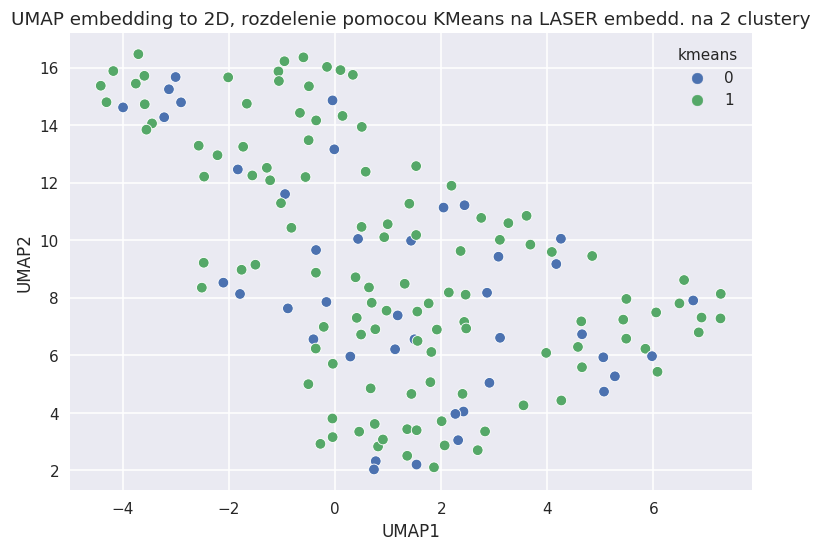

In [7]:
kmeans = KMeans(n_clusters=2, n_init=30, random_state=42).fit(laser_both)
embedding['kmeans'] = kmeans.labels_

plt.figure(dpi=110)
sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='kmeans')
plt.title('UMAP embedding to 2D, rozdelenie pomocou KMeans na LASER embedd. na 2 clustery')
plt.show()

### Pozorovanie

#### Graf 1

- UMAP vizuálne vyseparoval rozdiely medzi embeddingami oboch tried, avšak zdá sa, že podtried by tu mohlo byť viac (cca, 4-6)

#### Graf 2

- Bolo prevedené KMeans klustrovanie nad LASER embeddingami. Hľadané boli 2 rozpady.
- Kmeans si nebol schopný poradiť so separovaním žiadnej triedy
  - ak by sme zvýšili počet rozkladov na 4, rozdelenie by bolo podobne chaotické 
- Podľa všetkého je "zmätený" - to by mohlo signalizovať zlučiteľnosť oboch tried (do istej miery)

### Záver

- zdá sa, že tieto dve triedy by mohli byť zlučiteľné podľa KMeans
- UMAP však ukázal, že tento priestor embeddingov je nejakým spôsobom rozdeliteľný.
  - Otázkou zostáva či to bolo spôsobené iným jazykom (a teda trochu inou reprezentáciou v embedding priestore) alebo naozaj distinktnosťou oboch tried.

## Intenty z triedy "top up limit" (B77) podobné s intentami "limity" (t2b)

- pre presnosť použime originálne znenia intentov z B77 datasetu a použime LASER s anglickým jazykom

### Čo chceme ukázať?

- zoberme top/low 10 najpodobnejších intentov z oboch tried rozličných datasetov a porovnajme ich podobnosti pomocou LASERu.

### Hypotéza

- sú tieto dve triedy zlúčiteľné dohromady?

In [106]:
b77_lost = np.array(b77[b77['category'] == 'top_up_limits']['text'])
t2b_lost = np.array(t2b[t2b['kategorie'] == 'limity']['text_cz'])

print(f'limity: #t2b intentov: {len(t2b_lost)}, \ntop_up_limits: #b77 intentov: {len(b77_lost)}\n')

b77_lost_emb = laser.embed_sentences(b77_lost, lang='en')
t2b_lost_emb = laser.embed_sentences(t2b_lost, lang='cz')


cos_simil = cosine_similarity(t2b_lost_emb, b77_lost_emb)

top1 = np.argmax(cos_simil, axis=1)
top1_vals = np.max(cos_simil, axis=1)

b77_lost[top1]

res = sorted([(n, t, b) for t, b, n in zip(t2b_lost, b77_lost[top1], np.round(top1_vals, 3))], key=lambda x: x[0], reverse=True)

print(res)

limity: #t2b intentov: 22, 
top_up_limits: #b77 intentov: 79

[(0.812, 'Jaký mám limit na kartě?', 'What is the top-up limit for my card?'), (0.794, 'jaký limit mám na platební kartě?', 'What is the top-up limit for my card?'), (0.746, 'můžu změnit maximální limit na platbu kartou?', 'Can I increase my top-up maximum?'), (0.744, 'jak si změním limit na kartě?', 'What is the daily limit on my card?'), (0.728, 'Kolik zbývá do limitu na kreditní kartě? ', 'What is the top-up limit for my card?'), (0.706, 'Jak si změnit limity pro platby kartou?', 'What is the top-up limit for my card?'), (0.69, 'chci si zvýšit limit', 'Is there a top-up limit?'), (0.689, 'kolik mám maximálně povolený výběr z bankomatu?', "What is the highest amount of top ups I'm allowed?"), (0.687, 'Jak si můžu změnit limit bezpečnostní metody?', 'How can I information on my limit for top-ups?'), (0.67, 'navýšení limitu pro platbu kartou', 'What is the top-up limit for my card?'), (0.666, 'zvedni výši limitu výběru z ban

### Pozorovanie

- hore vidíme zoznam českých a anglických intentov a ich kosínovej podobnosti. vypísané sú všetky.
  - kazdý záznam je tvorený trojicou: cos simil, cz intent, en intent.
- pár s najvyššou podobnosťou 0,81: 'jak si změním limit na kartě?', 'How can I top-up my limit?' sa zdá, že sémanticky korešponduje, aj keď v prípade intentu z B77 si nechce limit zmeniť ale zvýšiť.
- pár 'Nastavení dočasných limitů', 'What are the top-up limits?' zasa moc nie, s hodnotou podobnosti 0,63.

### Záver

- sémantická diverzita intentov je vysoká nielen v t2b datasete, ale zdá sa, že aj v b77 datasete (toto sa ťažko kvantifikuje).
- trieda top-up limits však v kontexte českého bankovníctva nedáva zmysel, preto bude podľa všetkého vyhodená.
  - tieto triedy nezlučujeme


## Klastrovanie intentov z "top up limit" (B77) a "limity" (t2b)

### Čo chceme ukázať?

- vizualizáciu embeddingov intentov z oboch tried v 2 dimenziách (pomocou UMAPu)
- KMeans klastrovanie LASER embeddingov ale v 2D zobrazení UMAP embeddingov

### Hypotéza

- sú tieto dve triedy zlúčiteľné?

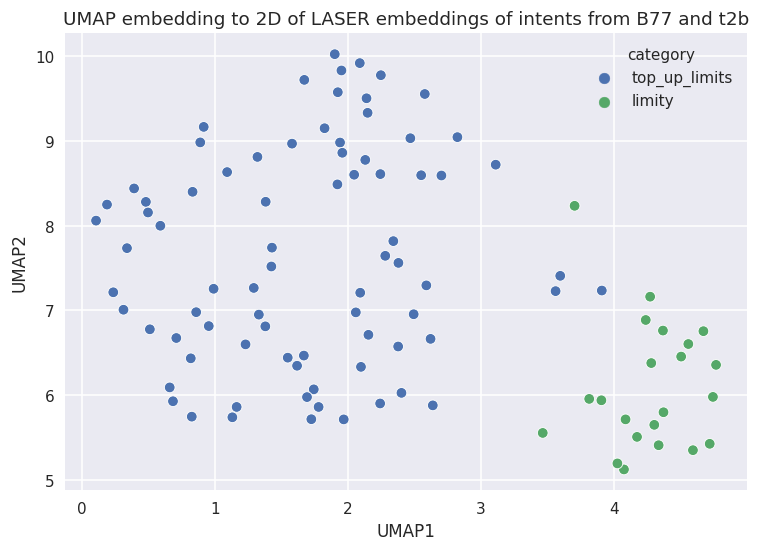

In [132]:
b77 = pd.read_csv('data_text2bank/cs_banking77/banking-train-translated.csv')
t2b = pd.read_csv('data_text2bank/clean-pairs-enhanced-sort.csv').dropna()

u = umap.UMAP(metric='cosine', random_state=999, n_neighbors=30, min_dist=.1)
b77_samp = b77[b77['category'] == 'top_up_limits'][['text', 'category']]
t2b_samp = t2b[t2b['kategorie'] == 'limity'][['text_cz', 'kategorie']]

b77_embds_laser = laser.embed_sentences(b77_samp['text'], lang='en')
t2b_embds_laser = laser.embed_sentences(t2b_samp['text_cz'], lang='cs')

laser_both = np.concatenate([b77_embds_laser, t2b_embds_laser])

ebds = u.fit_transform(laser_both)

b77_samp['laser'] = b77_embds_laser.tolist()
t2b_samp['laser'] = t2b_embds_laser.tolist()

t2b_samp.columns = ['text', 'category', 'laser']

data = pd.concat([b77_samp, t2b_samp]).reset_index()
ebds = u.fit_transform(data['laser'].tolist())
embedding = pd.DataFrame(ebds, columns = ['UMAP1','UMAP2'])

embedding, data
embedding = pd.concat([data, embedding], axis='columns')
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42).fit(laser_both)
embedding['kmeans'] = kmeans.labels_

plt.figure(dpi=110)
sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='category')
plt.title('UMAP embeddingov do 2D, rozdelenie na základe triedy')
plt.show()

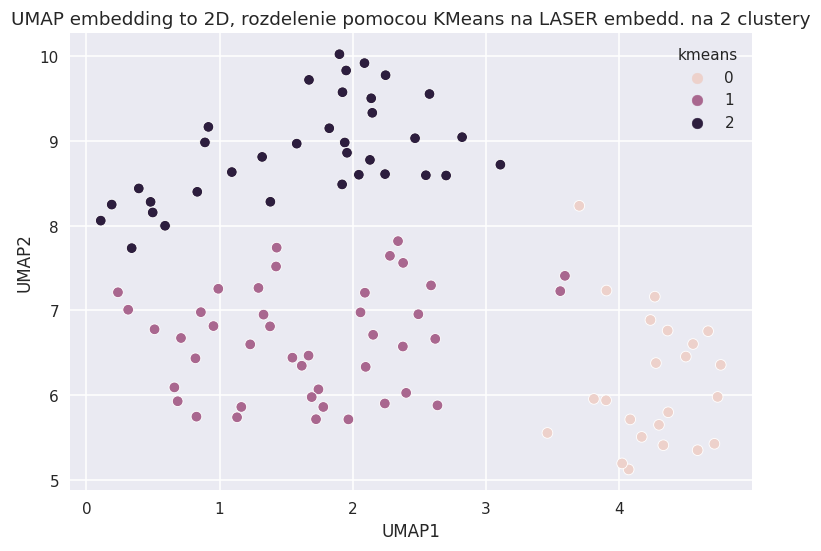

In [133]:
plt.figure(dpi=110)
sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='kmeans')
plt.title('UMAP embeddingov do 2D, rozdelenie pomocou KMeans na LASER embedd. na 3 clustery')
plt.show()

### Pozorovanie

#### Graf 1

- UMAP scatter plot bol vytvorený z LASER embeddingov tried "top_up_limits" a "limity"
- na scatter grafe je jasne vidieť rozlišnosť embedingov - to môže byť spôsobené rozdielnou sémantikou intentov, alebo samotným faktom, že jazyky skúmaných 2 tried sú rozličné.
- všimnime si však 3 "zatúlaných" modrých bodov medzi zelenými. Nebudeme ich bližšie skúmať. Podľa všetkého to budú tie najpodobnejšie, ktoré môžeme vidieť v predchádzajúcej analýze týchto 2 tried.

#### Graf 2

- Kmeans pomyselne rozelil priestor LASER embeddingov na 3 časti (ak by sme priestor rozdelili na 2 časti, tak by clustre 0 a 1 boli spolu)
- tieto dve časti síce úplne nekorešpondujú s naozajstnou divíziou oboch tried, ale môžeme sa domnievať, že aj triedu top up limits by bolo vhodné sémanticky rozbiť na dve podtriedy

### Záver

- zdá sa, že tieto dve triedy z rozličných datasetov nie je vhodné zlučovať, skôr rozbíjať a správne definovať podtriedy podľa sémantiky.
  - avšak najlepšia možnosť bude asi obe triedy vyhodiť

## Intenty z triedy "transfer timing" (B77) podobné s intentami "trvalé platby" (t2b)

- pre presnosť použime originálne znenia intentov z B77 datasetu a použime LASER s anglickým jazykom

### Čo chceme ukázať?

- zoberme top/low 10 najpodobnejších intentov z oboch tried rozličných datasetov a porovnajme ich podobnosti pomocou LASERu.

### Hypotéza

- sú tieto dve triedy zlúčiteľné dohromady?

In [150]:
b77_lost = np.array(b77[b77['category'] == 'transfer_timing']['text'])
t2b_lost = np.array(t2b[t2b['kategorie'] == 'trvalé platby']['text_cz'])

print(f'trvalé platby: #t2b intentov: {len(t2b_lost)}, \n transfer timing: #b77 intentov: {len(b77_lost)}\n')

b77_lost_emb = laser.embed_sentences(b77_lost, lang='en')
t2b_lost_emb = laser.embed_sentences(t2b_lost, lang='cz')


cos_simil = cosine_similarity(t2b_lost_emb, b77_lost_emb)

top1 = np.argmax(cos_simil, axis=1)
top1_vals = np.max(cos_simil, axis=1)

b77_lost[top1]

res = sorted([(n, t, b) for t, b, n in zip(t2b_lost, b77_lost[top1], np.round(top1_vals, 3))], key=lambda x: x[0], reverse=True)

print('TOP10: \n', res[1:11])
print('LOW10: \n', res[23:])

trvalé platby: #t2b intentov: 37, 
 transfer timing: #b77 intentov: 112

TOP10: 
 [(0.666, 'Co se mi strhne z účtu?', 'When will my money be in my account?'), (0.665, 'Kdy odešla splátka hypotéky?', 'How long does a transfer transaction take?'), (0.642, 'zobraz výpis trvalých plateb', 'what is the time frame for transfers'), (0.611, 'Jaká je suma mých měsíčních trvalých příkazů?', 'Where is my money transfer?'), (0.601, 'trvalé platby nastavení', 'what is the time frame for transfers'), (0.594, 'změň sumu pravidelné platby', 'what is the average wait for transfers'), (0.588, 'přidání trvalé platby', 'what is the average wait for transfers'), (0.582, 'nastavení trvalých plateb', 'what is the time frame for transfers'), (0.571, 'nastavit trvalou platbu za elektřinu', 'what is the average wait for transfers'), (0.564, 'Chci přeposílat 500 korun na svůj spořicí účet každý měsíc od 5.2.2021.', 'I need to transfer funds from China and quick expedition is crucial. Approximately how long does 

### Pozorovanie

- hore vidíme zoznam top/low 10 najpodobnejších českých a anglických intentov
- čísla kos. podobnosti je v prvej desiatke sú pomerne nízke: 0,66 až 0,56
  - kazdý záznam je tvorený trojicou: cos simil, cz intent, en intent.
- napr. najpodobnejší pár 'Co se mi strhne z účtu?', 'When will my money be in my account?' je sémanticky úplne mimo.

### Záver

- javí sa, že intenty týchto dvoch tried nie sú podobné.

## Klastering intentov "transfer timing" (B77) a "trvalé platby" (t2b)


### Čo chceme ukázať

- vizualizáciu embeddingov intentov z oboch tried v 2 dimenziách (pomocou UMAPu)
- KMeans klastrovanie LASER embeddingov ale v 2D zobrazení UMAP embeddingov

### Hypotéza

- sú tieto dve triedy zlúčiteľné?

UMAP params: (10, 0.9, 'cosine')


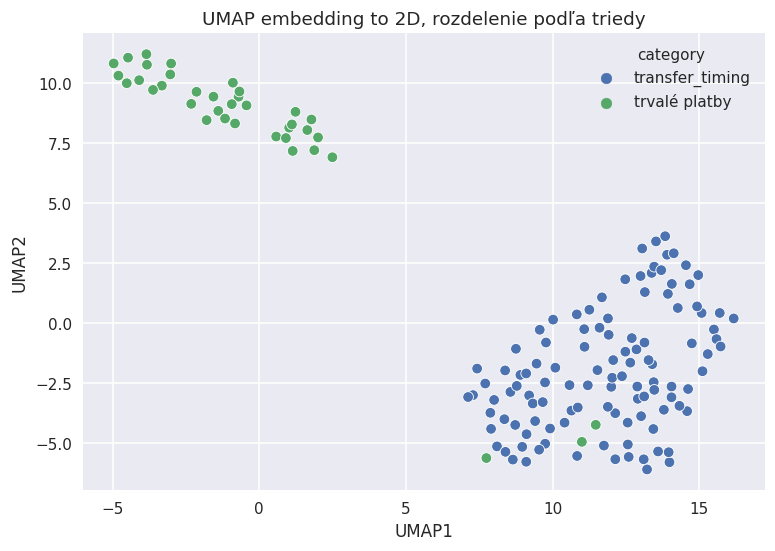

In [12]:
# b77 = pd.read_csv('data_text2bank/cs_banking77/banking-test-translated.csv')
# t2b = pd.read_csv('data_text2bank/clean-pairs-enhanced-sort.csv').dropna()

import itertools

for nei, md, metr in itertools.product([10], [.9], ['cosine']):
    # u = umap.UMAP(metric='cosine', random_state=999, n_neighbors=15, min_dist=.1)
    print('UMAP params:', (nei, md, metr))
    u = umap.UMAP(metric=metr, random_state=999, n_neighbors=nei, min_dist=md)
    b77_samp = b77[b77['category'] == 'transfer_timing'][['text', 'category']]
    t2b_samp = t2b[t2b['kategorie'] == 'trvalé platby'][['text_cz', 'kategorie']]

    b77_embds_laser = laser.embed_sentences(b77_samp['text'], lang='en')
    t2b_embds_laser = laser.embed_sentences(t2b_samp['text_cz'], lang='cs')

    laser_both = np.concatenate([b77_embds_laser, t2b_embds_laser])

    ebds = u.fit_transform(laser_both)

    b77_samp['laser'] = b77_embds_laser.tolist()
    t2b_samp['laser'] = t2b_embds_laser.tolist()

    t2b_samp.columns = ['text', 'category', 'laser']

    data = pd.concat([b77_samp, t2b_samp]).reset_index()
    ebds = u.fit_transform(data['laser'].tolist())
    embedding = pd.DataFrame(ebds, columns = ['UMAP1','UMAP2'])

    # embedding, data
    embedding = pd.concat([data, embedding], axis='columns').sample(frac=1).reset_index(drop=True)
    kmeans = KMeans(n_clusters=2, n_init=30 ,max_iter=600,  random_state=21).fit(laser_both)
    embedding['kmeans'] = kmeans.labels_
    plt.figure(dpi=110)
    sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='category')
    plt.title('UMAP embedding to 2D, rozdelenie podľa triedy')
    plt.show()

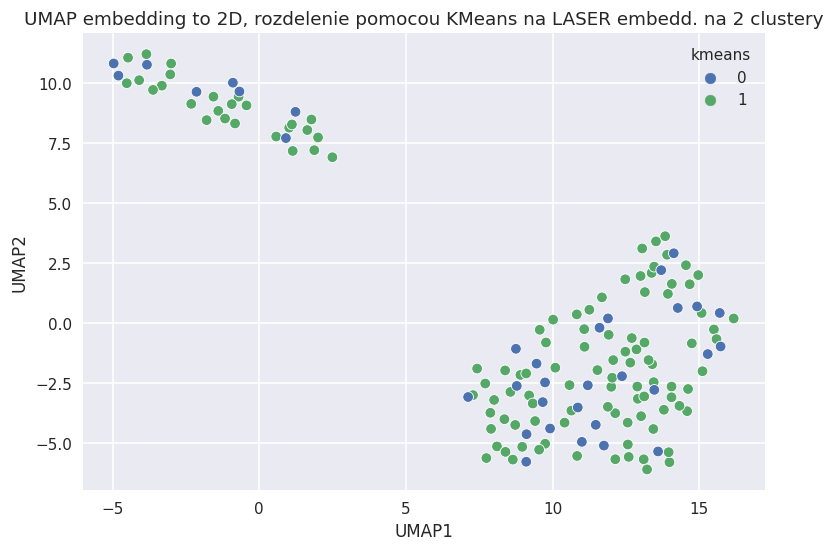

In [13]:
plt.figure(dpi=110)
sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding, hue='kmeans')
plt.title('UMAP embedding to 2D, rozdelenie pomocou KMeans na LASER embedd. na 2 clustery')
plt.show()

### Pozorovanie

#### Graf 1

- na grafe 1  je divízia bodov v 2D priestore podľa príslušiacej triedy 
- UMAP jasne našiel odlíšenie týchto dvoch tried

#### Graf 2

- použili sme KMeans algoritmus na nájdenie klastrov (v tomto prípade by sme očakávali práve 2 klastre)
- je viditeľné, že ak **v priestore laser embeddingov** vizualizované UMAPom existujú aspoň 2 klastre, sú určite rozličné od originál "klastrovania" podľa triedy
- KMeans klastrovanie je pomerne chaotické

### Záver

- Tieto dve triedy sa zjavne neprekrývajú, aj keď KMeans tvrdí opak.
- Nezlučujeme tieto dve triedy

## Trénovanie neurónovej siete za pomoci predtrénovaného RoBERTa modelu

- na platforme google colab prebehol transfer learning modelu FERNET od ZČU (RoBERTa) trénovaného čisto na českom jazyku (prečo zrovna FERNET? Dosahoval rozumné výsledky pri klasifikácii čisto na b77, navyše nie je tak veľký ako klasický BERT). 
- Za túto zmrznutú neurónku bola napojená klasifikačná vrstva pre 90 tried (13 z t2b a 77 z b77) na prevedenie transfer learningu.
- trénovacie dáta pozostávajú zo spojenia dvoch datasetov
  - preložených intentov a názvov tried datasetu b77 
  - upravených a vylepšených dátach t2b
    - v t2b boli upravené pravopisné, diakritické a iné chyby
    - Pomocou emimino.cz a googlu bolo pridaných asi tucet intentov ku triedam, kde nebolo aspoň 20 intentov/trieda
- trénovanie prebehlo na 9 epoch, kde pri 7. epoche bolo trénovanie zastavené (začal vzrastať validation loss) a model bol uložený ako checkpoint.
- testovací dataset je ten istý ako pri b77 (40intentov/trieda) ale pri t2b sa tak vysokého čísla dosiahnuť nedalo, takže ako trénovací tak testovací dataset t2b je stále nevyvážený.
  - t2b dataset bol rozdelený na trénovací a testovací v pomere 0,75

Datasety neboli nijak sémanticky zlučované

Nižšie môžeme vidieť výsledky testovacieho - evaluačného - datasetu t2b pripojeného k b77.

### Výsledky

Výsledky pre celý pripojený dataset:

     {'acc': 0.9078700811992505,
      'acc_bal': 0.883472230383995,
      'acc_top_3': 0.9734540911930044,
      'f1': 0.9069637007580451,
      'roc_auc': 0.996399289862738}

Výsledky pre čisto t2b test set:

    {'acc': 0.7049180327868853,
      'acc_bal': 0.6913462103507353,
      'acc_top_3': 0.8524590163934426,
      'f1': 0.756008735771233}

Výsledky pre čisto b77 test set:

    {'acc': 0.9159090909090909,
      'acc_bal': 0.9159090909090908,
      'acc_top_3': 0.9782467532467533,
      'f1': 0.9171692844233043}

### Pozorovanie

- je vidno, že testovací dataset je nebalansovaný (čistý b77 je balanced acc rovnaká ako acc)
- t2b príliš neuškodil b77 (čo sa týka sledovaných metrík)
- pri klasifikácii t2b spolu s b77 sa hodnoty t2b časti prekvapivo posunuli k lepšiemu (trénovanie čisto na t2b dátach f1 vyšlo v tomto prípade 0,65, akurát na SLAVIC-BERTovi, pri FERNET asi obdobne)
- oprava chýb a pridanie diakritiky do t2b pomohlo o 5% (dôkaz mám na screenshotoch)

### Záver 

- tento transfer learning model sa javí byť použiteľný
- bohvie, ako by to dopadlo na ostrých nečistených dátach (asi zle)
- tento prístup evaluácie spojeného datasetu môže mať svoje úskalia, ale ukazuje, že BERT modely sú dosť robustné 

# Záver

- ukázali sme podobnosť medzi embeddingami názvov tried t2b a b77
  - asi iba 3 páry z top3 výsledkov vyššie sa javili ako dostatočne sémanticky podobné
  - bolo prevedené manuálne (pozrem a vidím) párovanie EN ku CZ triedam - bol objavený ďalší možný pár:
    - "Lost or stolen card" ku 'ztratil jsem platební kartu'
  
- pri pokuse o zlúčenie vyššie spomenutých tried z UMAP analýz vysvitlo, že zlučiteľné triedy by boli iba
  - "Lost or stolen card" a 'ztratil jsem platební kartu'
  - "pending_transfer" a "čekající platby" ale s potrebou ďalšej manuálnej sémantickej analýzy pre overenie zlúčenia
    -  vyžadovalo by sa čistenie sémantiky intentov pre zvýšenie granularity výslednej zlúčenej triedy

- pomocou komplikovaného RoBERTa modelu sme klasifikovali intenty z oboch datasetov, bez spájania a vyhadzovania tried (oba datasety také, aké sme ich "dostali")
- výsledky sú pozoruhodné, jednoznačne lepšie oproti predošlým klasifikáciám len za pomoci embeddingov a kosínovej podobnosti.
  - výsledky klasifikácie boli zobrazené pre celkový spojený dataset, a potom pre čisto časť t2b a b77

## Verdikt

- datasety sú zlúčiteľné len na 2 triedach
- trénovanie a rozumná klasifikácia je možná, a hodnoty sledovaných metrík sú vcelku rozumné avšak treba dodať viac vzoriek pre t2b dataset
- kľúčové slová, zdá sa, lepšie klasifikujú t2b dataset
  - problém je v tom, že sme nepoužili model kľúčových slov len na validačnej vzorke ako tu ale na celom datasete a expertné "trénovanie" je predsalen lepšie ako strojové
  - poznámka autora: tento bod nemyslím príliš vážne, overiť to musím ešte nejak inak

# Hypotézy na preverenie

- ak sa prehrabem intentami pre rôzne triedy, zvýšim sémantickú granularitu minimálne tým, že významové celky v rámci triedy rozbijem do viacerých podtried: Aké by potom boli výsledky podobnej analýzy? 
  - pomohol by som si vôbec rozbitím už tak malých dát s vysokým počtom tried zvýšením počtu tried hlavne pre t2b?
- ako by dopadla klasifikácia pomocou BERT modelu, ak by sme 
  - zlúčili vyššie spomínané triedy a irelevantné triedy vyhodili,
  - nahradili číslice (sumy, č. účtov) nejakým spoločným tokenom?

## Ďalšie otázky

- ako si vytvorím znalostnú bázu, z ktorej by som mohol čerpať? Má to byť nejaká vysvetľujúca množina viet ku triede?
  - ak by existovala, ako by prebiehala klasifikácia s pomocou znalostnej báze?
  - mohlo by to slúžiť len ako pomôcka pri zbere nových dát?
  - ako by figurovala v celej diplomke?
- ako správne pozmeniť názvy krátkych / nedostatočne granulárnych tried tak, aby podobná analýza vyšla príjemnejšie na čítanie?
